# Simple ACT Training on MNIST

This notebook demonstrates training a simple ACT (Adaptive Computation Time) model on MNIST with visualization of iteration distribution.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import our simple ACT model
from model import SimpleACTNet, ACTLoss
from training import SimpleACTTrainer, get_mnist_loaders

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


c:\Users\chaow\miniconda3\envs\default\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.7.0+cu128
CUDA available: True
Using device: cuda


## Create Model and Data Loaders


In [2]:
# Create model
model = SimpleACTNet(
    input_dim=784,  # 28x28 flattened
    hidden_dim=256,
    num_classes=10,   # 10 digits
    max_iterations=5
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Max iterations: {model.max_iterations}")

# Get data loaders
batch_size = 64
train_loader, test_loader = get_mnist_loaders(batch_size=batch_size)
print(f"\nTrain batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Model parameters: 998,540
Max iterations: 5

Train batches: 938
Test batches: 157


## Custom Training Loop with Iteration Tracking


In [3]:
class ImprovedACTTrainer:
    def __init__(self, model, device, learning_rate=1e-3, act_weight=0.1):
        self.model = model.to(device)
        self.device = device
        self.act_weight = act_weight
        
        # ACT loss
        self.act_loss_fn = ACTLoss(efficiency_penalty=0.01)
        
        # Single optimizer
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Track metrics
        self.train_history = defaultdict(list)
        self.iteration_distribution = defaultdict(int)
        
    def train_epoch(self, train_loader, epoch):
        self.model.train()
        
        total_loss = 0
        total_acc = 0
        total_batches = 0
        
        # Track iteration usage
        iteration_counts = []
        batch_losses = []
        batch_accs = []
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.view(images.size(0), -1).to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass with ACT info
            output, act_info = self.model(images, return_act_info=True)
            
            # Classification loss
            cls_loss = nn.CrossEntropyLoss()(output, labels)
            
            # ACT losses - pass required arguments
            act_loss, act_metrics = self.act_loss_fn(
                act_info=act_info,
                labels=labels,
                logits=output,
                update_critic=(batch_idx % 2 == 0)  # Alternate between critic and actor updates
            )
            
            # Total loss
            loss = cls_loss + self.act_weight * act_loss
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
            self.optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(output.data, 1)
            accuracy = (predicted == labels).float().mean().item()
            
            # Track metrics
            total_loss += loss.item()
            total_acc += accuracy
            total_batches += 1
            batch_losses.append(cls_loss.item())
            batch_accs.append(accuracy)
            
            # Extract iteration distribution
            k_star = act_info.get('k_star', torch.ones_like(labels) * self.model.max_iterations)
            for k in k_star.cpu().numpy():
                iteration_counts.append(int(k))
                self.iteration_distribution[int(k)] += 1
            
            # Update progress bar
            avg_k = k_star.float().mean().item()
            pbar.set_postfix({
                'loss': f"{cls_loss.item():.4f}",
                'acc': f"{accuracy*100:.1f}%",
                'k_avg': f"{avg_k:.2f}",
                'k_dist': self._format_distribution(k_star),
                'agree': f"{act_metrics.get('agreement', 0)*100:.1f}%"
            })
        
        # Store epoch metrics
        avg_loss = total_loss / total_batches
        avg_acc = total_acc / total_batches
        
        return {
            'loss': avg_loss,
            'accuracy': avg_acc,
            'iteration_counts': iteration_counts,
            'batch_losses': batch_losses,
            'batch_accs': batch_accs
        }
    
    def _format_distribution(self, k_star):
        """Format iteration distribution for display"""
        unique, counts = torch.unique(k_star, return_counts=True)
        dist = []
        for k, count in zip(unique, counts):
            dist.append(f"{int(k)}:{count.item()}")
        return " ".join(dist)
    
    def evaluate(self, test_loader):
        self.model.eval()
        
        total_loss = 0
        total_acc = 0
        total_batches = 0
        iteration_counts = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(images.size(0), -1).to(self.device)
                labels = labels.to(self.device)
                
                output, act_info = self.model(images, return_act_info=True)
                
                loss = nn.CrossEntropyLoss()(output, labels)
                _, predicted = torch.max(output.data, 1)
                accuracy = (predicted == labels).float().mean().item()
                
                total_loss += loss.item()
                total_acc += accuracy
                total_batches += 1
                
                # Track iterations
                k_star = act_info.get('k_star', torch.ones_like(labels) * self.model.max_iterations)
                iteration_counts.extend(k_star.cpu().numpy().tolist())
        
        return {
            'loss': total_loss / total_batches,
            'accuracy': total_acc / total_batches,
            'iteration_counts': iteration_counts
        }

# Initialize trainer
trainer = ImprovedACTTrainer(
    model=model,
    device=device,
    learning_rate=1e-3,
    act_weight=0.1
)

print("Trainer initialized successfully!")


Trainer initialized successfully!


## Visualization Functions


In [4]:
def plot_iteration_distribution(iteration_counts, title="Iteration Distribution"):
    """Plot histogram of iteration usage"""
    plt.figure(figsize=(10, 5))
    
    # Create histogram
    unique_iters = list(range(1, model.max_iterations + 1))
    counts = [iteration_counts.count(i) for i in unique_iters]
    
    # Plot
    bars = plt.bar(unique_iters, counts, color='steelblue', edgecolor='black')
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(count)}', ha='center', va='bottom')
    
    plt.xlabel('Number of Iterations')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(unique_iters)
    plt.grid(True, alpha=0.3)
    
    # Calculate statistics
    if iteration_counts:
        mean_iter = np.mean(iteration_counts)
        std_iter = np.std(iteration_counts)
        plt.axvline(mean_iter, color='red', linestyle='--', label=f'Mean: {mean_iter:.2f}')
        plt.legend()
        
        # Print statistics
        print(f"Mean iterations: {mean_iter:.2f}")
        print(f"Std iterations: {std_iter:.2f}")
        print(f"Min iterations: {min(iteration_counts)}")
        print(f"Max iterations: {max(iteration_counts)}")
        print(f"Distribution: {dict(zip(unique_iters, counts))}")
    
    plt.tight_layout()
    plt.show()

def plot_training_curves(train_history, test_history=None):
    """Plot training curves"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Loss curve
    axes[0].plot(train_history['losses'], label='Train Loss')
    if test_history:
        axes[0].plot(test_history['losses'], label='Test Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Curve')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy curve
    axes[1].plot([acc*100 for acc in train_history['accuracies']], label='Train Acc')
    if test_history:
        axes[1].plot([acc*100 for acc in test_history['accuracies']], label='Test Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Accuracy Curve')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Average iterations curve
    axes[2].plot(train_history['avg_iterations'], label='Train Avg k')
    if test_history:
        axes[2].plot(test_history['avg_iterations'], label='Test Avg k')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Average Iterations')
    axes[2].set_title('Average Iterations per Sample')
    axes[2].axhline(y=model.max_iterations, color='r', linestyle='--', alpha=0.5, label=f'Max: {model.max_iterations}')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Visualization functions defined!")


Visualization functions defined!


## Training Loop with Iteration Tracking



Epoch 1/5


Epoch 1: 100%|██████████| 938/938 [00:14<00:00, 64.65it/s, loss=0.1510, acc=93.8%, k_avg=2.56, k_dist=2:14 3:18, agree=0.0%]   



📊 Epoch 1 Summary:
  Train - Loss: 0.3078, Acc: 91.68%, Avg k: 2.75
  Test  - Loss: 0.1507, Acc: 95.90%, Avg k: 3.00

📈 Iteration Distribution - Epoch 1
Mean iterations: 2.75
Std iterations: 0.45
Min iterations: 2
Max iterations: 5
Distribution: {1: 0, 2: 15589, 3: 44015, 4: 395, 5: 1}


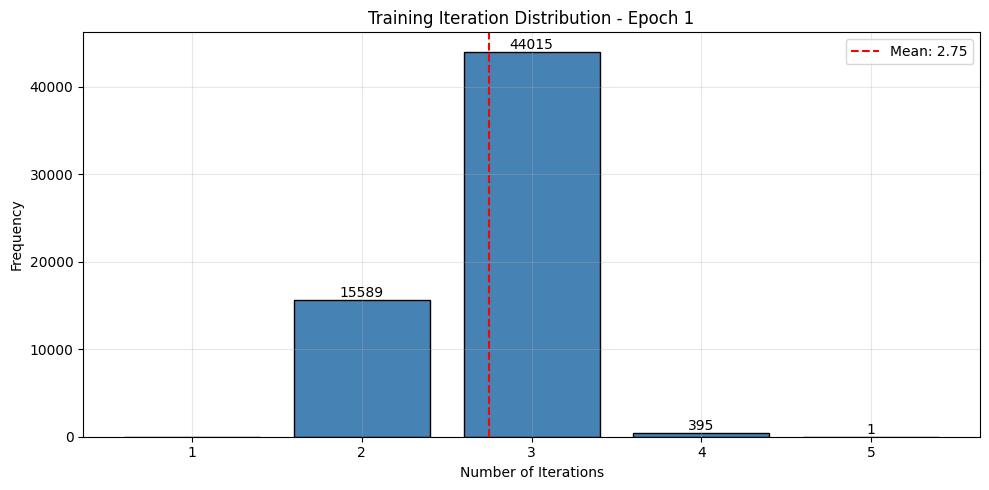

Mean iterations: 3.00
Std iterations: 0.00
Min iterations: 3
Max iterations: 3
Distribution: {1: 0, 2: 0, 3: 10000, 4: 0, 5: 0}


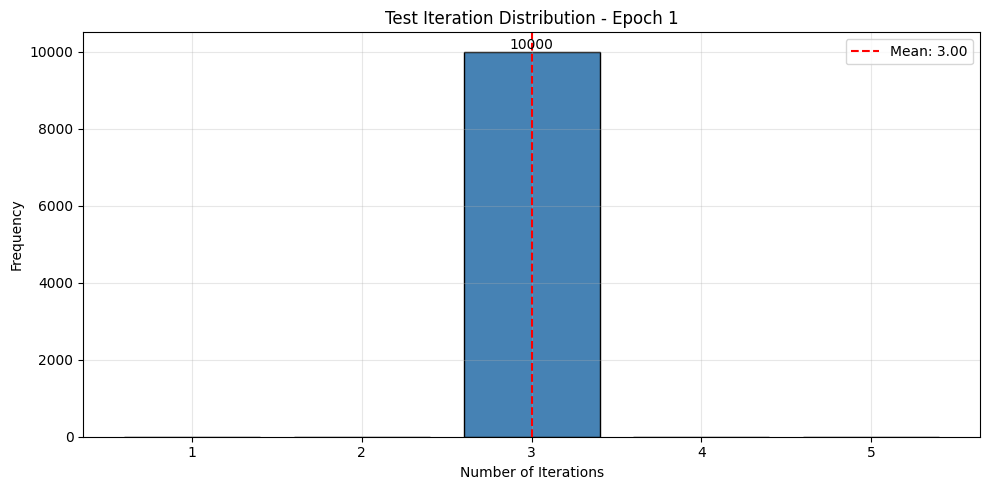


Epoch 2/5


Epoch 2: 100%|██████████| 938/938 [00:14<00:00, 66.15it/s, loss=0.0200, acc=100.0%, k_avg=2.78, k_dist=2:7 3:25, agree=0.0%]    



📊 Epoch 2 Summary:
  Train - Loss: 0.1571, Acc: 96.07%, Avg k: 2.72
  Test  - Loss: 0.1035, Acc: 97.24%, Avg k: 3.00

Epoch 3/5


Epoch 3: 100%|██████████| 938/938 [00:14<00:00, 65.36it/s, loss=0.0802, acc=96.9%, k_avg=2.72, k_dist=2:9 3:23, agree=0.0%]  



📊 Epoch 3 Summary:
  Train - Loss: 0.1151, Acc: 97.13%, Avg k: 2.72
  Test  - Loss: 0.0961, Acc: 97.34%, Avg k: 3.00

📈 Iteration Distribution - Epoch 3
Mean iterations: 2.72
Std iterations: 0.45
Min iterations: 2
Max iterations: 3
Distribution: {1: 0, 2: 16759, 3: 43241, 4: 0, 5: 0}


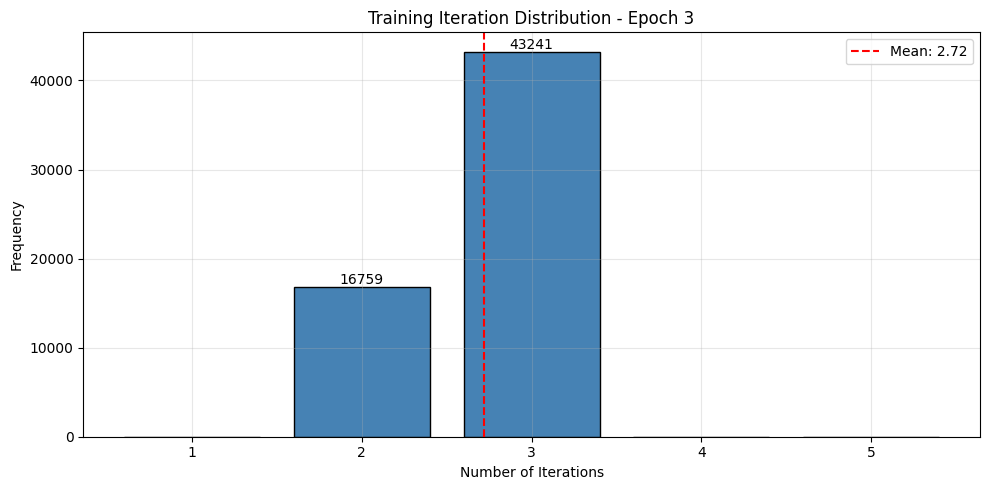

Mean iterations: 3.00
Std iterations: 0.00
Min iterations: 3
Max iterations: 3
Distribution: {1: 0, 2: 0, 3: 10000, 4: 0, 5: 0}


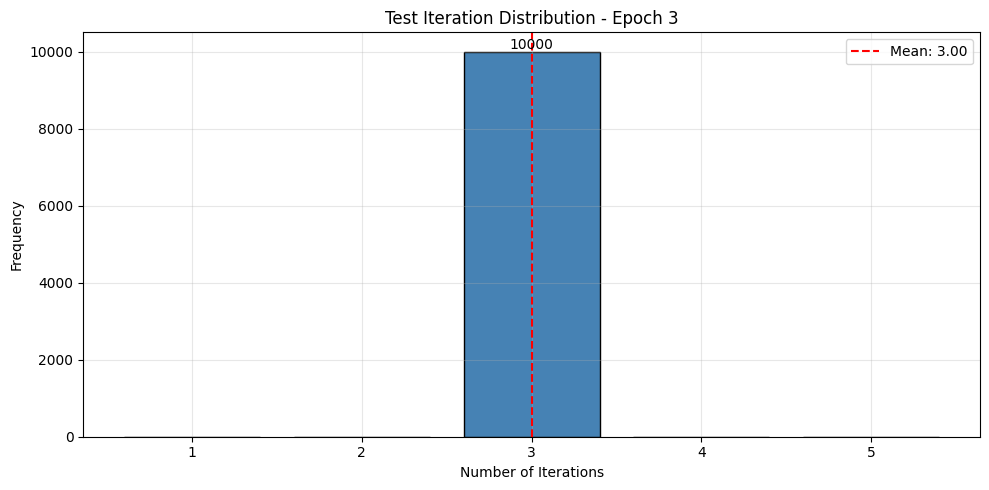


Epoch 4/5


Epoch 4: 100%|██████████| 938/938 [00:14<00:00, 65.46it/s, loss=0.0054, acc=100.0%, k_avg=2.88, k_dist=2:4 3:28, agree=0.0%] 



📊 Epoch 4 Summary:
  Train - Loss: 0.0922, Acc: 97.74%, Avg k: 2.73
  Test  - Loss: 0.0897, Acc: 97.52%, Avg k: 3.00

Epoch 5/5


Epoch 5: 100%|██████████| 938/938 [00:14<00:00, 66.01it/s, loss=0.0301, acc=96.9%, k_avg=2.78, k_dist=2:7 3:25, agree=0.0%]  



📊 Epoch 5 Summary:
  Train - Loss: 0.0787, Acc: 98.08%, Avg k: 2.73
  Test  - Loss: 0.0789, Acc: 97.91%, Avg k: 3.00

📈 Iteration Distribution - Epoch 5
Mean iterations: 2.73
Std iterations: 0.45
Min iterations: 2
Max iterations: 3
Distribution: {1: 0, 2: 16387, 3: 43613, 4: 0, 5: 0}


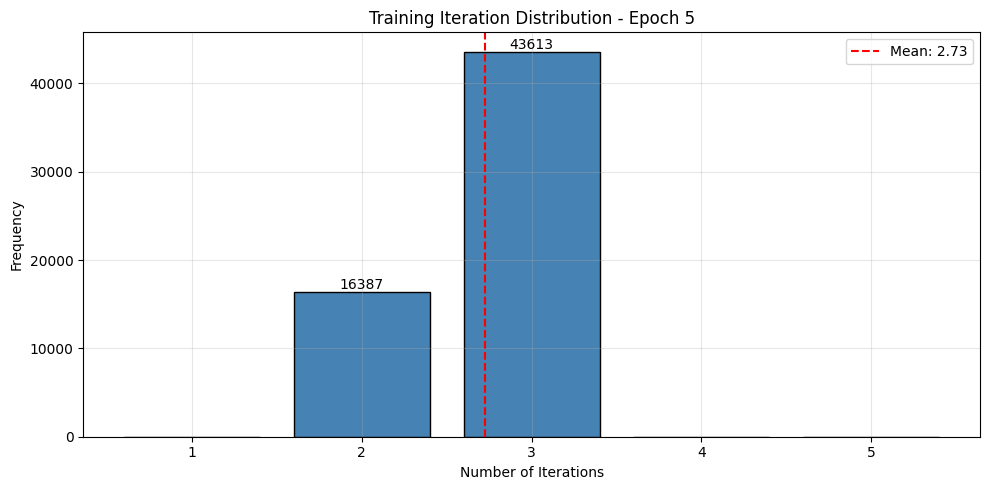

Mean iterations: 3.00
Std iterations: 0.00
Min iterations: 3
Max iterations: 3
Distribution: {1: 0, 2: 0, 3: 10000, 4: 0, 5: 0}


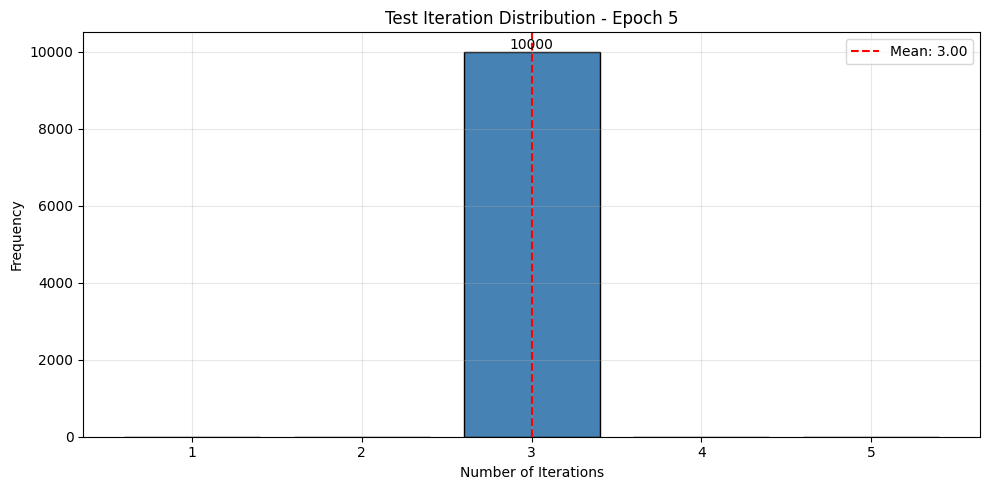


Training Complete!


In [5]:
# Training configuration
num_epochs = 5
train_history = {'losses': [], 'accuracies': [], 'avg_iterations': []}
test_history = {'losses': [], 'accuracies': [], 'avg_iterations': []}

# Train model
for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('='*60)
    
    # Train
    train_metrics = trainer.train_epoch(train_loader, epoch+1)
    train_history['losses'].append(train_metrics['loss'])
    train_history['accuracies'].append(train_metrics['accuracy'])
    
    # Calculate average iterations
    avg_train_iter = np.mean(train_metrics['iteration_counts']) if train_metrics['iteration_counts'] else model.max_iterations
    train_history['avg_iterations'].append(avg_train_iter)
    
    # Evaluate
    test_metrics = trainer.evaluate(test_loader)
    test_history['losses'].append(test_metrics['loss'])
    test_history['accuracies'].append(test_metrics['accuracy'])
    
    # Calculate average iterations for test
    avg_test_iter = np.mean(test_metrics['iteration_counts']) if test_metrics['iteration_counts'] else model.max_iterations
    test_history['avg_iterations'].append(avg_test_iter)
    
    # Print epoch summary
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"  Train - Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['accuracy']*100:.2f}%, Avg k: {avg_train_iter:.2f}")
    print(f"  Test  - Loss: {test_metrics['loss']:.4f}, Acc: {test_metrics['accuracy']*100:.2f}%, Avg k: {avg_test_iter:.2f}")
    
    # Visualize iteration distribution for this epoch
    if epoch % 2 == 0 or epoch == num_epochs - 1:  # Show every 2 epochs and last epoch
        print(f"\n📈 Iteration Distribution - Epoch {epoch+1}")
        plot_iteration_distribution(
            train_metrics['iteration_counts'], 
            title=f"Training Iteration Distribution - Epoch {epoch+1}"
        )
        
        # Also show test distribution
        plot_iteration_distribution(
            test_metrics['iteration_counts'],
            title=f"Test Iteration Distribution - Epoch {epoch+1}"
        )

print("\n" + "="*60)
print("Training Complete!")
print("="*60)


## Final Training Curves


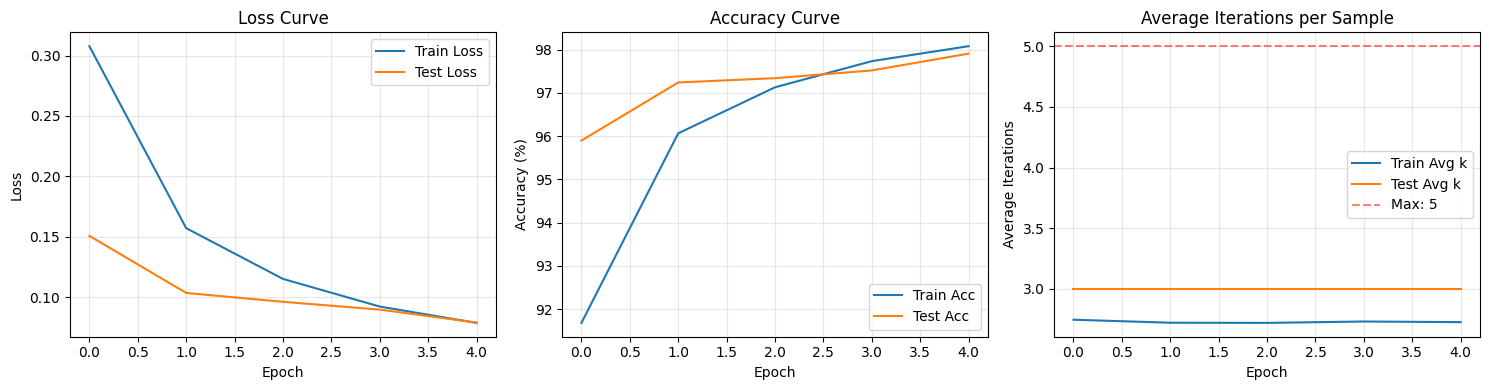


📊 Final Training Statistics:
  Best Train Acc: 98.08%
  Best Test Acc: 97.91%
  Final Avg Iterations (Train): 2.73
  Final Avg Iterations (Test): 3.00
  Computation Savings: 45.5%


In [6]:
# Plot final training curves
plot_training_curves(train_history, test_history)

# Print final statistics
print("\n📊 Final Training Statistics:")
print(f"  Best Train Acc: {max(train_history['accuracies'])*100:.2f}%")
print(f"  Best Test Acc: {max(test_history['accuracies'])*100:.2f}%")
print(f"  Final Avg Iterations (Train): {train_history['avg_iterations'][-1]:.2f}")
print(f"  Final Avg Iterations (Test): {test_history['avg_iterations'][-1]:.2f}")
print(f"  Computation Savings: {(1 - train_history['avg_iterations'][-1]/model.max_iterations)*100:.1f}%")


## Analyze Iteration Pattern by Digit Class


Analyzing: 100%|██████████| 157/157 [00:04<00:00, 36.68it/s] 



📊 Iteration Usage by Digit Class:
--------------------------------------------------
Digit    Avg k      Std k      Accuracy  
--------------------------------------------------
0        3.00       0.00       99.1      %
1        3.00       0.00       99.0      %
2        3.00       0.00       97.7      %
3        3.00       0.00       97.2      %
4        3.00       0.00       96.6      %
5        3.00       0.00       98.7      %
6        3.00       0.00       98.3      %
7        3.00       0.00       98.6      %
8        3.00       0.00       96.4      %
9        3.00       0.00       97.2      %
--------------------------------------------------
Overall  3.00      


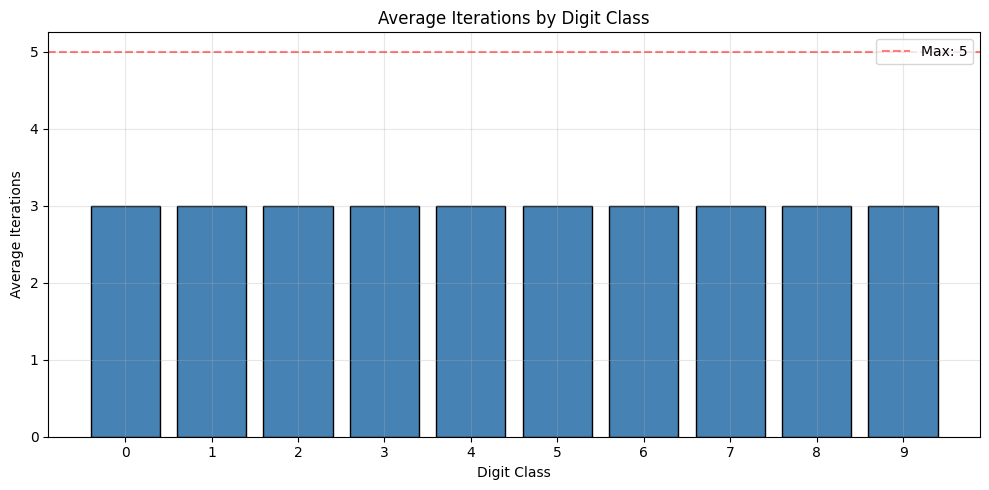

In [7]:
# Analyze iteration usage by digit class
def analyze_by_class(model, test_loader, device):
    """Analyze which digit classes need more iterations"""
    model.eval()
    
    class_iterations = defaultdict(list)
    class_accuracies = defaultdict(list)
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Analyzing"):
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            
            output, act_info = model(images, return_act_info=True)
            _, predicted = torch.max(output.data, 1)
            
            k_star = act_info['k_star']
            
            for label, k, pred in zip(labels, k_star, predicted):
                class_iterations[label.item()].append(k.item())
                class_accuracies[label.item()].append(int(pred == label))
    
    # Compute statistics per class
    print("\n📊 Iteration Usage by Digit Class:")
    print("-" * 50)
    print(f"{'Digit':<8} {'Avg k':<10} {'Std k':<10} {'Accuracy':<10}")
    print("-" * 50)
    
    avg_iterations_per_class = []
    for digit in range(10):
        iters = class_iterations[digit]
        accs = class_accuracies[digit]
        avg_k = np.mean(iters)
        std_k = np.std(iters)
        acc = np.mean(accs) * 100
        avg_iterations_per_class.append(avg_k)
        print(f"{digit:<8} {avg_k:<10.2f} {std_k:<10.2f} {acc:<10.1f}%")
    
    print("-" * 50)
    print(f"{'Overall':<8} {np.mean([v for vals in class_iterations.values() for v in vals]):<10.2f}")
    
    # Plot bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(range(10), avg_iterations_per_class, color='steelblue', edgecolor='black')
    plt.xlabel('Digit Class')
    plt.ylabel('Average Iterations')
    plt.title('Average Iterations by Digit Class')
    plt.xticks(range(10))
    plt.grid(True, alpha=0.3)
    plt.axhline(y=model.max_iterations, color='r', linestyle='--', alpha=0.5, label=f'Max: {model.max_iterations}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return class_iterations

# Run analysis
class_iterations = analyze_by_class(model, test_loader, device)
